<a href="https://colab.research.google.com/github/SonChungMan/Machine-Learning/blob/main/TimeSeries_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA

train_data = pd.read_csv("trainSet.csv")
#test_data = pd.read_csv("examSet.csv")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pmdarima
from pmdarima import auto_arima

     |████████████████████████████████| 1.4 MB 4.2 MB/s 
     |████████████████████████████████| 9.8 MB 49.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
gas = train_data.iloc[:,32:68]   # 36 months
train_index = train_data.iloc[:,0]

print(gas)

     GAS_MONTH_1  GAS_MONTH_2  ...  GAS_MONTH_35  GAS_MONTH_36
0            NaN          NaN  ...           NaN           NaN
1            NaN          NaN  ...           NaN           NaN
2            NaN          NaN  ...           NaN           NaN
3            NaN          NaN  ...           NaN           NaN
4            NaN          NaN  ...           NaN           NaN
..           ...          ...  ...           ...           ...
275      80178.0      75621.0  ...       16344.0       13089.0
276      48177.0      85713.0  ...       19869.0       20691.0
277       3075.0     145722.0  ...        9525.0       10137.0
278      51975.0      91236.0  ...       16623.0       16056.0
279      27546.0      66612.0  ...       15495.0       16449.0

[280 rows x 36 columns]


In [ ]:
gas['NaN_cnt'] = gas.isnull().sum(1)

gas = pd.concat([train_index,gas], axis = 1)
gas.set_index('No',inplace = True)                      # 생산정 번호를 index로
gas

,GAS_MONTH_1,GAS_MONTH_2,GAS_MONTH_3,GAS_MONTH_4,GAS_MONTH_5,GAS_MONTH_6,GAS_MONTH_7,GAS_MONTH_8,GAS_MONTH_9,GAS_MONTH_10,GAS_MONTH_11,GAS_MONTH_12,GAS_MONTH_13,GAS_MONTH_14,GAS_MONTH_15,GAS_MONTH_16,GAS_MONTH_17,GAS_MONTH_18,GAS_MONTH_19,GAS_MONTH_20,GAS_MONTH_21,GAS_MONTH_22,GAS_MONTH_23,GAS_MONTH_24,GAS_MONTH_25,GAS_MONTH_26,GAS_MONTH_27,GAS_MONTH_28,GAS_MONTH_29,GAS_MONTH_30,GAS_MONTH_31,GAS_MONTH_32,GAS_MONTH_33,GAS_MONTH_34,GAS_MONTH_35,GAS_MONTH_36,NaN_cnt
No,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36
372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36
383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36
395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36
397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,80178.0,75621.0,61350.0,53199.0,48366.0,41274.0,36843.0,33798.0,32988.0,29613.0,26802.0,28488.0,27231.0,24786.0,26313.0,25461.0,26175.0,25599.0,25392.0,23601.0,21450.0,20403.0,19854.0,13296.0,22113.0,21831.0,22734.0,21135.0,20505.0,19425.0,19368.0,18495.0,17349.0,16494.0,16344.0,13089.0,0
716,48177.0,85713.0,0.0,12315.0,121689.0,123162.0,71886.0,30033.0,70137.0,66873.0,65700.0,59979.0,46977.0,41661.0,39807.0,38343.0,36234.0,35121.0,32538.0,30093.0,28695.0,23238.0,28353.0,29040.0,23772.0,22578.0,21570.0,19785.0,20931.0,20328.0,21036.0,21096.0,20781.0,20004.0,19869.0,20691.0,0
718,3075.0,145722.0,0.0,108516.0,98457.0,72279.0,56502.0,50325.0,40173.0,34749.0,0.0,54738.0,47895.0,25527.0,24543.0,19230.0,15744.0,21243.0,20574.0,16308.0,16413.0,15288.0,14772.0,15888.0,15849.0,13680.0,14652.0,14562.0,13971.0,12393.0,10959.0,12138.0,10692.0,9918.0,9525.0,10137.0,0


In [ ]:
gas.drop(gas.loc[gas['NaN_cnt']==36].index, inplace=True)   #기존 생산 데이터 없는 생산정 제거
gas.drop(['NaN_cnt'],axis=1,inplace=True)

In [ ]:
gas = gas.assign(first6_avg = lambda x: (x['GAS_MONTH_1']+x['GAS_MONTH_2']+x['GAS_MONTH_3']+x['GAS_MONTH_4']+x['GAS_MONTH_5']+x['GAS_MONTH_6'])/6)
gas

,GAS_MONTH_1,GAS_MONTH_2,GAS_MONTH_3,GAS_MONTH_4,GAS_MONTH_5,GAS_MONTH_6,GAS_MONTH_7,GAS_MONTH_8,GAS_MONTH_9,GAS_MONTH_10,GAS_MONTH_11,GAS_MONTH_12,GAS_MONTH_13,GAS_MONTH_14,GAS_MONTH_15,GAS_MONTH_16,GAS_MONTH_17,GAS_MONTH_18,GAS_MONTH_19,GAS_MONTH_20,GAS_MONTH_21,GAS_MONTH_22,GAS_MONTH_23,GAS_MONTH_24,GAS_MONTH_25,GAS_MONTH_26,GAS_MONTH_27,GAS_MONTH_28,GAS_MONTH_29,GAS_MONTH_30,GAS_MONTH_31,GAS_MONTH_32,GAS_MONTH_33,GAS_MONTH_34,GAS_MONTH_35,GAS_MONTH_36,first6_avg
No,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,129303.0,162132.0,126960.0,118344.0,123348.0,110403.0,97038.0,82473.0,81354.0,80334.0,75747.0,70500.0,65016.0,61455.0,60612.0,59049.0,56967.0,55557.0,54384.0,51453.0,52503.0,47718.0,46356.0,44790.0,43866.0,42549.0,41910.0,39252.0,39261.0,46926.0,41079.0,48309.0,46437.0,36555.0,35895.0,35400.0,128415.0
3,1482.0,151515.0,235626.0,136260.0,126114.0,123303.0,114399.0,98718.0,82953.0,82551.0,78069.0,74856.0,69711.0,65205.0,63327.0,60165.0,57267.0,53136.0,53154.0,48078.0,45210.0,46650.0,41196.0,38886.0,36075.0,35217.0,33219.0,33723.0,32271.0,31977.0,36258.0,25923.0,24729.0,35724.0,26070.0,23388.0,129050.0
5,204702.0,237939.0,140163.0,107802.0,106329.0,60282.0,70878.0,72888.0,69816.0,65454.0,60054.0,49563.0,42678.0,42549.0,39663.0,37278.0,35049.0,31302.0,31227.0,29490.0,0.0,0.0,13917.0,19857.0,21729.0,20052.0,21618.0,22710.0,25584.0,27090.0,25713.0,32997.0,24762.0,26496.0,25263.0,25278.0,142869.5
7,122931.0,178464.0,125649.0,92613.0,93096.0,99567.0,54078.0,45219.0,63117.0,55056.0,51564.0,45282.0,37257.0,39834.0,37641.0,31953.0,31446.0,48615.0,37506.0,40932.0,0.0,4839.0,25617.0,30039.0,24693.0,20943.0,25638.0,23046.0,18423.0,30969.0,25932.0,24387.0,27138.0,24939.0,23334.0,21852.0,118720.0
9,176409.0,211509.0,150930.0,95274.0,93339.0,88740.0,75798.0,98001.0,101079.0,89520.0,72282.0,44712.0,42243.0,40095.0,37668.0,37560.0,38157.0,34578.0,35910.0,33882.0,52929.0,33858.0,30177.0,26553.0,25755.0,25230.0,25395.0,28158.0,27123.0,28479.0,24810.0,23709.0,28008.0,20445.0,19320.0,19827.0,136033.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,80178.0,75621.0,61350.0,53199.0,48366.0,41274.0,36843.0,33798.0,32988.0,29613.0,26802.0,28488.0,27231.0,24786.0,26313.0,25461.0,26175.0,25599.0,25392.0,23601.0,21450.0,20403.0,19854.0,13296.0,22113.0,21831.0,22734.0,21135.0,20505.0,19425.0,19368.0,18495.0,17349.0,16494.0,16344.0,13089.0,59998.0
716,48177.0,85713.0,0.0,12315.0,121689.0,123162.0,71886.0,30033.0,70137.0,66873.0,65700.0,59979.0,46977.0,41661.0,39807.0,38343.0,36234.0,35121.0,32538.0,30093.0,28695.0,23238.0,28353.0,29040.0,23772.0,22578.0,21570.0,19785.0,20931.0,20328.0,21036.0,21096.0,20781.0,20004.0,19869.0,20691.0,65176.0
718,3075.0,145722.0,0.0,108516.0,98457.0,72279.0,56502.0,50325.0,40173.0,34749.0,0.0,54738.0,47895.0,25527.0,24543.0,19230.0,15744.0,21243.0,20574.0,16308.0,16413.0,15288.0,14772.0,15888.0,15849.0,13680.0,14652.0,14562.0,13971.0,12393.0,10959.0,12138.0,10692.0,9918.0,9525.0,10137.0,71341.5


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


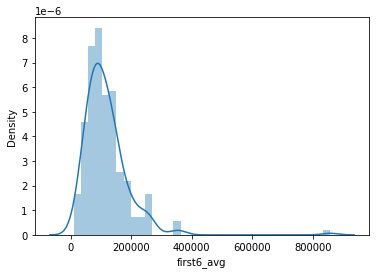

In [ ]:
sns.distplot(gas['first6_avg'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


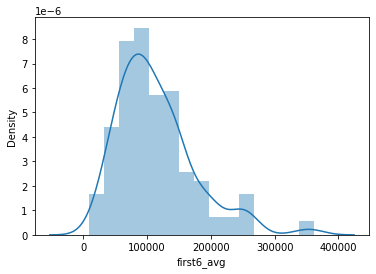

In [ ]:
gas.drop(gas.loc[gas['first6_avg']>800000].index, inplace=True)
sns.distplot(gas['first6_avg'])

In [ ]:
gas['first6_avg'].median()

100911.5

In [ ]:
df_1 = gas.loc[gas['first6_avg'] < 100000]
df_2 = gas.loc[gas['first6_avg'] >= 100911.5]
print(df_1.shape, df_2.shape)

(113, 37) (116, 37)


In [ ]:
df_4 = df_2.loc[df_2['first6_avg'] >= 150000]
df_3 = df_2.loc[df_2['first6_avg'] < 150000]
df_5 = df_1.loc[df_1['first6_avg'] > 70000]
df_6 = df_1.loc[df_1['first6_avg'] < 70000]
print(df_5.shape,df_6.shape)

(56, 37) (57, 37)


In [ ]:
train_gas = gas.copy()
train_gas.replace(0, value = train_gas.median(), inplace=True)  # 0을 모든 생산정의 미디안으로 대체
train_gas = train_gas.assign(first6_avg = lambda x: (x['GAS_MONTH_1']+x['GAS_MONTH_2']+x['GAS_MONTH_3']+x['GAS_MONTH_4']+x['GAS_MONTH_5']+x['GAS_MONTH_6'])/6)

In [ ]:
train_gas = train_gas.reset_index(drop=True)  # index reset
train_gas

,GAS_MONTH_1,GAS_MONTH_2,GAS_MONTH_3,GAS_MONTH_4,GAS_MONTH_5,GAS_MONTH_6,GAS_MONTH_7,GAS_MONTH_8,GAS_MONTH_9,GAS_MONTH_10,GAS_MONTH_11,GAS_MONTH_12,GAS_MONTH_13,GAS_MONTH_14,GAS_MONTH_15,GAS_MONTH_16,GAS_MONTH_17,GAS_MONTH_18,GAS_MONTH_19,GAS_MONTH_20,GAS_MONTH_21,GAS_MONTH_22,GAS_MONTH_23,GAS_MONTH_24,GAS_MONTH_25,GAS_MONTH_26,GAS_MONTH_27,GAS_MONTH_28,GAS_MONTH_29,GAS_MONTH_30,GAS_MONTH_31,GAS_MONTH_32,GAS_MONTH_33,GAS_MONTH_34,GAS_MONTH_35,GAS_MONTH_36
0,129303.0,162132.0,126960.0,118344.0,123348.0,110403.0,97038.0,82473.0,81354.0,80334.0,75747.0,70500.0,65016.0,61455.0,60612.0,59049.0,56967.0,55557.0,54384.0,51453.0,52503.0,47718.0,46356.0,44790.0,43866.0,42549.0,41910.0,39252.0,39261.0,46926.0,41079.0,48309.0,46437.0,36555.0,35895.0,35400.0
1,1482.0,151515.0,235626.0,136260.0,126114.0,123303.0,114399.0,98718.0,82953.0,82551.0,78069.0,74856.0,69711.0,65205.0,63327.0,60165.0,57267.0,53136.0,53154.0,48078.0,45210.0,46650.0,41196.0,38886.0,36075.0,35217.0,33219.0,33723.0,32271.0,31977.0,36258.0,25923.0,24729.0,35724.0,26070.0,23388.0
2,204702.0,237939.0,140163.0,107802.0,106329.0,60282.0,70878.0,72888.0,69816.0,65454.0,60054.0,49563.0,42678.0,42549.0,39663.0,37278.0,35049.0,31302.0,31227.0,29490.0,32403.0,30759.0,13917.0,19857.0,21729.0,20052.0,21618.0,22710.0,25584.0,27090.0,25713.0,32997.0,24762.0,26496.0,25263.0,25278.0
3,122931.0,178464.0,125649.0,92613.0,93096.0,99567.0,54078.0,45219.0,63117.0,55056.0,51564.0,45282.0,37257.0,39834.0,37641.0,31953.0,31446.0,48615.0,37506.0,40932.0,32403.0,4839.0,25617.0,30039.0,24693.0,20943.0,25638.0,23046.0,18423.0,30969.0,25932.0,24387.0,27138.0,24939.0,23334.0,21852.0
4,176409.0,211509.0,150930.0,95274.0,93339.0,88740.0,75798.0,98001.0,101079.0,89520.0,72282.0,44712.0,42243.0,40095.0,37668.0,37560.0,38157.0,34578.0,35910.0,33882.0,52929.0,33858.0,30177.0,26553.0,25755.0,25230.0,25395.0,28158.0,27123.0,28479.0,24810.0,23709.0,28008.0,20445.0,19320.0,19827.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,80178.0,75621.0,61350.0,53199.0,48366.0,41274.0,36843.0,33798.0,32988.0,29613.0,26802.0,28488.0,27231.0,24786.0,26313.0,25461.0,26175.0,25599.0,25392.0,23601.0,21450.0,20403.0,19854.0,13296.0,22113.0,21831.0,22734.0,21135.0,20505.0,19425.0,19368.0,18495.0,17349.0,16494.0,16344.0,13089.0
227,48177.0,85713.0,105558.0,12315.0,121689.0,123162.0,71886.0,30033.0,70137.0,66873.0,65700.0,59979.0,46977.0,41661.0,39807.0,38343.0,36234.0,35121.0,32538.0,30093.0,28695.0,23238.0,28353.0,29040.0,23772.0,22578.0,21570.0,19785.0,20931.0,20328.0,21036.0,21096.0,20781.0,20004.0,19869.0,20691.0
228,3075.0,145722.0,105558.0,108516.0,98457.0,72279.0,56502.0,50325.0,40173.0,34749.0,60312.0,54738.0,47895.0,25527.0,24543.0,19230.0,15744.0,21243.0,20574.0,16308.0,16413.0,15288.0,14772.0,15888.0,15849.0,13680.0,14652.0,14562.0,13971.0,12393.0,10959.0,12138.0,10692.0,9918.0,9525.0,10137.0
229,51975.0,91236.0,8898.0,134994.0,129606.0,120942.0,88485.0,91473.0,69015.0,56391.0,104382.0,82155.0,46533.0,41739.0,42621.0,40539.0,41532.0,35751.0,37893.0,28893.0,26214.0,24264.0,19836.0,20436.0,20625.0,18150.0,16569.0,16386.0,18177.0,20151.0,19848.0,21009.0,18258.0,16479.0,16623.0,16056.0


In [ ]:
real = train_gas.iloc[:,-6:]  # 마지막 6개월 따로 떼놓기
train_gas = train_gas.iloc[:,:-6]
train_gas
real

,GAS_MONTH_31,GAS_MONTH_32,GAS_MONTH_33,GAS_MONTH_34,GAS_MONTH_35,GAS_MONTH_36
0,41079.0,48309.0,46437.0,36555.0,35895.0,35400.0
1,36258.0,25923.0,24729.0,35724.0,26070.0,23388.0
2,25713.0,32997.0,24762.0,26496.0,25263.0,25278.0
3,25932.0,24387.0,27138.0,24939.0,23334.0,21852.0
4,24810.0,23709.0,28008.0,20445.0,19320.0,19827.0
...,...,...,...,...,...,...
226,19368.0,18495.0,17349.0,16494.0,16344.0,13089.0
227,21036.0,21096.0,20781.0,20004.0,19869.0,20691.0
228,10959.0,12138.0,10692.0,9918.0,9525.0,10137.0
229,19848.0,21009.0,18258.0,16479.0,16623.0,16056.0


#df_1

In [ ]:
df_2.replace(0, value = df_2.median(), inplace=True)  # 0을 모든 생산정의 미디안으로 대체
df_2 = df_2.reset_index(drop=True)  # index reset
df_2.drop(['first6_avg'],axis=1,inplace=True)
df_2

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,GAS_MONTH_1,GAS_MONTH_2,GAS_MONTH_3,GAS_MONTH_4,GAS_MONTH_5,GAS_MONTH_6,GAS_MONTH_7,GAS_MONTH_8,GAS_MONTH_9,GAS_MONTH_10,GAS_MONTH_11,GAS_MONTH_12,GAS_MONTH_13,GAS_MONTH_14,GAS_MONTH_15,GAS_MONTH_16,GAS_MONTH_17,GAS_MONTH_18,GAS_MONTH_19,GAS_MONTH_20,GAS_MONTH_21,GAS_MONTH_22,GAS_MONTH_23,GAS_MONTH_24,GAS_MONTH_25,GAS_MONTH_26,GAS_MONTH_27,GAS_MONTH_28,GAS_MONTH_29,GAS_MONTH_30,GAS_MONTH_31,GAS_MONTH_32,GAS_MONTH_33,GAS_MONTH_34,GAS_MONTH_35,GAS_MONTH_36
0,129303.0,162132.0,126960.0,118344.0,123348.0,110403.0,97038.0,82473.0,81354.0,80334.0,75747.0,70500.0,65016.0,61455.0,60612.0,59049.0,56967.0,55557.0,54384.0,51453.0,52503.0,47718.0,46356.0,44790.0,43866.0,42549.0,41910.0,39252.0,39261.0,46926.0,41079.0,48309.0,46437.0,36555.0,35895.0,35400.0
1,1482.0,151515.0,235626.0,136260.0,126114.0,123303.0,114399.0,98718.0,82953.0,82551.0,78069.0,74856.0,69711.0,65205.0,63327.0,60165.0,57267.0,53136.0,53154.0,48078.0,45210.0,46650.0,41196.0,38886.0,36075.0,35217.0,33219.0,33723.0,32271.0,31977.0,36258.0,25923.0,24729.0,35724.0,26070.0,23388.0
2,204702.0,237939.0,140163.0,107802.0,106329.0,60282.0,70878.0,72888.0,69816.0,65454.0,60054.0,49563.0,42678.0,42549.0,39663.0,37278.0,35049.0,31302.0,31227.0,29490.0,42703.5,43728.0,13917.0,19857.0,21729.0,20052.0,21618.0,22710.0,25584.0,27090.0,25713.0,32997.0,24762.0,26496.0,25263.0,25278.0
3,122931.0,178464.0,125649.0,92613.0,93096.0,99567.0,54078.0,45219.0,63117.0,55056.0,51564.0,45282.0,37257.0,39834.0,37641.0,31953.0,31446.0,48615.0,37506.0,40932.0,42703.5,4839.0,25617.0,30039.0,24693.0,20943.0,25638.0,23046.0,18423.0,30969.0,25932.0,24387.0,27138.0,24939.0,23334.0,21852.0
4,176409.0,211509.0,150930.0,95274.0,93339.0,88740.0,75798.0,98001.0,101079.0,89520.0,72282.0,44712.0,42243.0,40095.0,37668.0,37560.0,38157.0,34578.0,35910.0,33882.0,52929.0,33858.0,30177.0,26553.0,25755.0,25230.0,25395.0,28158.0,27123.0,28479.0,24810.0,23709.0,28008.0,20445.0,19320.0,19827.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,159462.0,259068.0,274740.0,252552.0,261180.0,253236.0,226746.0,197697.0,181722.0,167826.0,147141.0,151188.0,149307.0,131985.0,139329.0,132711.0,115167.0,116079.0,109584.0,107574.0,42703.5,43728.0,7227.0,7629.0,4380.0,4053.0,7026.0,8328.0,9129.0,16512.0,29199.0,18489.0,16509.0,14841.0,17796.0,18867.0
112,71760.0,135456.0,265485.0,230217.0,232449.0,212205.0,180669.0,155466.0,138051.0,126672.0,99288.0,108669.0,132519.0,91464.0,105813.0,97914.0,84690.0,86451.0,79284.0,77100.0,42703.5,43728.0,12495.0,19452.0,22776.0,25017.0,26823.0,26601.0,28758.0,30078.0,31134.0,30642.0,30936.0,31995.0,34299.0,35511.0
113,148071.0,165789.0,32886.0,194085.0,256914.0,153201.0,115137.0,96711.0,72318.0,6.0,103524.0,101598.0,61173.0,40770.0,44814.0,53535.0,36615.0,34731.0,37398.0,24195.0,23229.0,21936.0,26574.0,38887.5,32472.0,18462.0,16926.0,19842.0,17973.0,19209.0,16587.0,15837.0,16200.0,15999.0,14805.0,15312.0
114,78561.0,124932.0,118371.0,113550.0,95529.0,78555.0,65202.0,56175.0,49674.0,58020.0,40584.0,36234.0,33954.0,17799.0,57.0,3657.0,3411.0,8922.0,9810.0,9642.0,8571.0,8097.0,9222.0,8886.0,7938.0,9270.0,7710.0,8442.0,9480.0,8676.0,8511.0,8502.0,8346.0,7821.0,7593.0,7350.0


In [ ]:
real = df_2.iloc[:,-6:]  # 마지막 6개월 따로 떼놓기
df_2 = df_2.iloc[:,:-6]

In [ ]:
mean = pd.DataFrame(df_6.mean())
mean = mean.reset_index(drop=True)  # index reset
mean = mean.transpose()
#mean.loc[0]
tfdata, LD = stats.boxcox(mean.loc[0])

In [ ]:
LD

0.2511769534265778

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


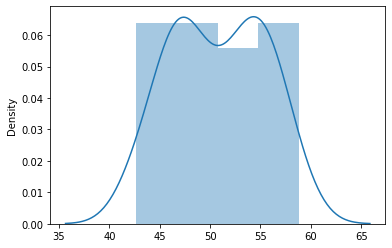

In [ ]:
sns.distplot(tfdata)

In [ ]:
stepwise_fit = auto_arima(tfdata, trace=True, suppress_warnings=True) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=100.589, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=102.426, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=102.279, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=101.884, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.489 seconds


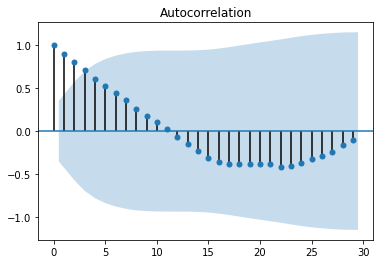

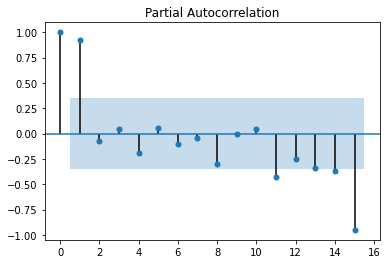

In [ ]:
tfdata = pd.DataFrame(tfdata)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(tfdata, lags = 29)
plot_pacf(tfdata)
plt.show()

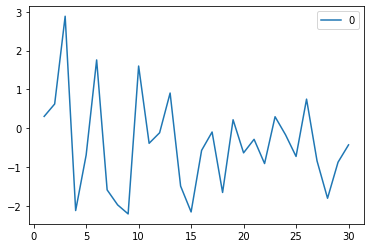

In [ ]:
diff_1 = tfdata.diff(periods=1).iloc[1:]
diff_1.plot()

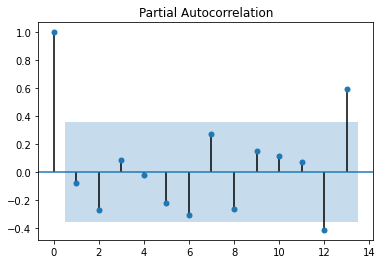

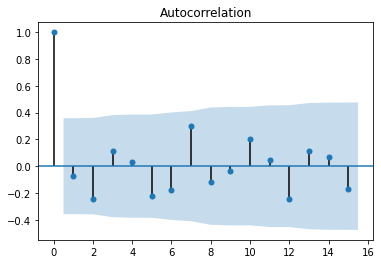

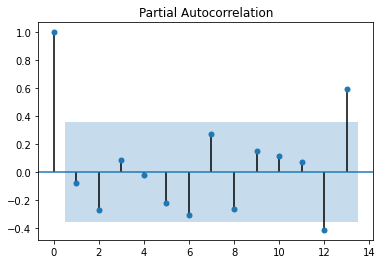

In [ ]:
plot_acf(diff_1)   # boxcox, 1차 차분 이후의 acf,pacf
plot_pacf(diff_1, lags=13)

In [ ]:
from statsmodels.tsa.api import ARMA
model = ARMA(diff_1,order=(0,0))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      0   No. Observations:                   30
Model:                     ARMA(0, 0)   Log Likelihood                 -48.294
Method:                           css   S.D. of innovations              1.210
Date:                Wed, 29 Dec 2021   AIC                            100.589
Time:                        13:20:38   BIC                            103.391
Sample:                             0   HQIC                           101.485
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4124      0.221     -1.866      0.072      -0.845       0.021


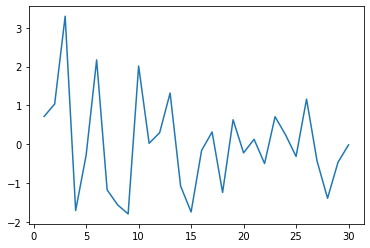

In [ ]:
resid = model_fit.resid[:]
resid.plot()

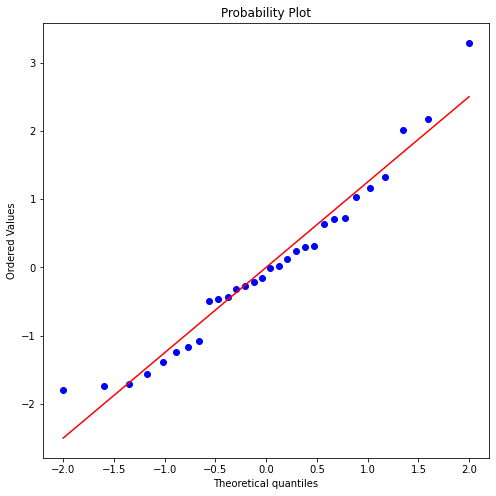

In [ ]:
from scipy.stats import probplot
 
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
 
ax = fig.add_subplot()
probplot(resid, dist='norm',plot=ax) ## qq plot 출력
plt.show()

In [ ]:
stats.shapiro(resid)

(0.9564809799194336, 0.2511630356311798)

In [ ]:
series = df_2.iloc[7]   #
diff_2 = series.diff(periods=1).iloc[1:]

In [ ]:
# 모델 fitting
model = ARMA(diff_1,order=(0,0))
model_fit = model.fit()

In [ ]:
pred_y = model_fit.forecast(steps=6)[0].tolist()
real_y = real.iloc[7].tolist()  #

In [ ]:
F = sum(pred_y)/6
A = sum(real_y)/6

In [ ]:
error_list = []

In [ ]:
error_list.append(2*abs(F-A)/(abs(F)+abs(A)))

In [ ]:
error_list

[2.0]

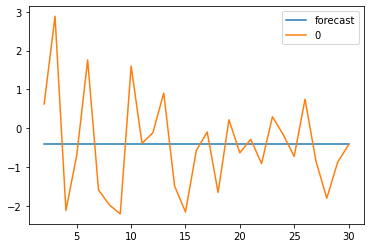

In [ ]:
fig = model_fit.plot_predict()

In [ ]:
error_list = []
for x in range(len(df_1)):
  series = df_2.iloc[x]   #
  diff_1 = series.diff(periods=1).iloc[1:]
  model = ARMA(diff_1,order=(0,0))
  model_fit = model.fit()
  pred_y = model_fit.forecast(steps=6)[0].tolist()
  real_y = real.iloc[x].tolist()  #
  F = sum(pred_y)/6
  A = sum(real_y)/6
  error_list.append(2*abs(F-A)/(abs(F)+abs(A)))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ig

In [ ]:
sum(error_list)/len(error_list)*100

199.2214479069797

In [ ]:
train_gas.replace(0, value = train_gas.median(), inplace=True)  # 0을 모든 생산정의 미디안으로 대체


In [ ]:
train_gas = gas.copy()
train_gas = train_gas.reset_index(drop=True)  # index reset
train_gas.drop(['first6_avg'],axis=1,inplace=True)
train_gas


,GAS_MONTH_1,GAS_MONTH_2,GAS_MONTH_3,GAS_MONTH_4,GAS_MONTH_5,GAS_MONTH_6,GAS_MONTH_7,GAS_MONTH_8,GAS_MONTH_9,GAS_MONTH_10,GAS_MONTH_11,GAS_MONTH_12,GAS_MONTH_13,GAS_MONTH_14,GAS_MONTH_15,GAS_MONTH_16,GAS_MONTH_17,GAS_MONTH_18,GAS_MONTH_19,GAS_MONTH_20,GAS_MONTH_21,GAS_MONTH_22,GAS_MONTH_23,GAS_MONTH_24,GAS_MONTH_25,GAS_MONTH_26,GAS_MONTH_27,GAS_MONTH_28,GAS_MONTH_29,GAS_MONTH_30,GAS_MONTH_31,GAS_MONTH_32,GAS_MONTH_33,GAS_MONTH_34,GAS_MONTH_35,GAS_MONTH_36
0,129303.0,162132.0,126960.0,118344.0,123348.0,110403.0,97038.0,82473.0,81354.0,80334.0,75747.0,70500.0,65016.0,61455.0,60612.0,59049.0,56967.0,55557.0,54384.0,51453.0,52503.0,47718.0,46356.0,44790.0,43866.0,42549.0,41910.0,39252.0,39261.0,46926.0,41079.0,48309.0,46437.0,36555.0,35895.0,35400.0
1,1482.0,151515.0,235626.0,136260.0,126114.0,123303.0,114399.0,98718.0,82953.0,82551.0,78069.0,74856.0,69711.0,65205.0,63327.0,60165.0,57267.0,53136.0,53154.0,48078.0,45210.0,46650.0,41196.0,38886.0,36075.0,35217.0,33219.0,33723.0,32271.0,31977.0,36258.0,25923.0,24729.0,35724.0,26070.0,23388.0
2,204702.0,237939.0,140163.0,107802.0,106329.0,60282.0,70878.0,72888.0,69816.0,65454.0,60054.0,49563.0,42678.0,42549.0,39663.0,37278.0,35049.0,31302.0,31227.0,29490.0,0.0,0.0,13917.0,19857.0,21729.0,20052.0,21618.0,22710.0,25584.0,27090.0,25713.0,32997.0,24762.0,26496.0,25263.0,25278.0
3,122931.0,178464.0,125649.0,92613.0,93096.0,99567.0,54078.0,45219.0,63117.0,55056.0,51564.0,45282.0,37257.0,39834.0,37641.0,31953.0,31446.0,48615.0,37506.0,40932.0,0.0,4839.0,25617.0,30039.0,24693.0,20943.0,25638.0,23046.0,18423.0,30969.0,25932.0,24387.0,27138.0,24939.0,23334.0,21852.0
4,176409.0,211509.0,150930.0,95274.0,93339.0,88740.0,75798.0,98001.0,101079.0,89520.0,72282.0,44712.0,42243.0,40095.0,37668.0,37560.0,38157.0,34578.0,35910.0,33882.0,52929.0,33858.0,30177.0,26553.0,25755.0,25230.0,25395.0,28158.0,27123.0,28479.0,24810.0,23709.0,28008.0,20445.0,19320.0,19827.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,80178.0,75621.0,61350.0,53199.0,48366.0,41274.0,36843.0,33798.0,32988.0,29613.0,26802.0,28488.0,27231.0,24786.0,26313.0,25461.0,26175.0,25599.0,25392.0,23601.0,21450.0,20403.0,19854.0,13296.0,22113.0,21831.0,22734.0,21135.0,20505.0,19425.0,19368.0,18495.0,17349.0,16494.0,16344.0,13089.0
227,48177.0,85713.0,0.0,12315.0,121689.0,123162.0,71886.0,30033.0,70137.0,66873.0,65700.0,59979.0,46977.0,41661.0,39807.0,38343.0,36234.0,35121.0,32538.0,30093.0,28695.0,23238.0,28353.0,29040.0,23772.0,22578.0,21570.0,19785.0,20931.0,20328.0,21036.0,21096.0,20781.0,20004.0,19869.0,20691.0
228,3075.0,145722.0,0.0,108516.0,98457.0,72279.0,56502.0,50325.0,40173.0,34749.0,0.0,54738.0,47895.0,25527.0,24543.0,19230.0,15744.0,21243.0,20574.0,16308.0,16413.0,15288.0,14772.0,15888.0,15849.0,13680.0,14652.0,14562.0,13971.0,12393.0,10959.0,12138.0,10692.0,9918.0,9525.0,10137.0
229,51975.0,91236.0,8898.0,134994.0,129606.0,120942.0,88485.0,91473.0,69015.0,56391.0,104382.0,82155.0,46533.0,41739.0,42621.0,40539.0,41532.0,35751.0,37893.0,28893.0,26214.0,24264.0,19836.0,20436.0,20625.0,18150.0,16569.0,16386.0,18177.0,20151.0,19848.0,21009.0,18258.0,16479.0,16623.0,16056.0


In [ ]:
real = train_gas.iloc[:,-6:]  # 마지막 6개월 따로 떼놓기
train_gas = train_gas.iloc[:,:-6]
train_gas

,GAS_MONTH_1,GAS_MONTH_2,GAS_MONTH_3,GAS_MONTH_4,GAS_MONTH_5,GAS_MONTH_6,GAS_MONTH_7,GAS_MONTH_8,GAS_MONTH_9,GAS_MONTH_10,GAS_MONTH_11,GAS_MONTH_12,GAS_MONTH_13,GAS_MONTH_14,GAS_MONTH_15,GAS_MONTH_16,GAS_MONTH_17,GAS_MONTH_18,GAS_MONTH_19,GAS_MONTH_20,GAS_MONTH_21,GAS_MONTH_22,GAS_MONTH_23,GAS_MONTH_24,GAS_MONTH_25,GAS_MONTH_26,GAS_MONTH_27,GAS_MONTH_28,GAS_MONTH_29,GAS_MONTH_30
0,129303.0,162132.0,126960.0,118344.0,123348.0,110403.0,97038.0,82473.0,81354.0,80334.0,75747.0,70500.0,65016.0,61455.0,60612.0,59049.0,56967.0,55557.0,54384.0,51453.0,52503.0,47718.0,46356.0,44790.0,43866.0,42549.0,41910.0,39252.0,39261.0,46926.0
1,1482.0,151515.0,235626.0,136260.0,126114.0,123303.0,114399.0,98718.0,82953.0,82551.0,78069.0,74856.0,69711.0,65205.0,63327.0,60165.0,57267.0,53136.0,53154.0,48078.0,45210.0,46650.0,41196.0,38886.0,36075.0,35217.0,33219.0,33723.0,32271.0,31977.0
2,204702.0,237939.0,140163.0,107802.0,106329.0,60282.0,70878.0,72888.0,69816.0,65454.0,60054.0,49563.0,42678.0,42549.0,39663.0,37278.0,35049.0,31302.0,31227.0,29490.0,0.0,0.0,13917.0,19857.0,21729.0,20052.0,21618.0,22710.0,25584.0,27090.0
3,122931.0,178464.0,125649.0,92613.0,93096.0,99567.0,54078.0,45219.0,63117.0,55056.0,51564.0,45282.0,37257.0,39834.0,37641.0,31953.0,31446.0,48615.0,37506.0,40932.0,0.0,4839.0,25617.0,30039.0,24693.0,20943.0,25638.0,23046.0,18423.0,30969.0
4,176409.0,211509.0,150930.0,95274.0,93339.0,88740.0,75798.0,98001.0,101079.0,89520.0,72282.0,44712.0,42243.0,40095.0,37668.0,37560.0,38157.0,34578.0,35910.0,33882.0,52929.0,33858.0,30177.0,26553.0,25755.0,25230.0,25395.0,28158.0,27123.0,28479.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,80178.0,75621.0,61350.0,53199.0,48366.0,41274.0,36843.0,33798.0,32988.0,29613.0,26802.0,28488.0,27231.0,24786.0,26313.0,25461.0,26175.0,25599.0,25392.0,23601.0,21450.0,20403.0,19854.0,13296.0,22113.0,21831.0,22734.0,21135.0,20505.0,19425.0
227,48177.0,85713.0,0.0,12315.0,121689.0,123162.0,71886.0,30033.0,70137.0,66873.0,65700.0,59979.0,46977.0,41661.0,39807.0,38343.0,36234.0,35121.0,32538.0,30093.0,28695.0,23238.0,28353.0,29040.0,23772.0,22578.0,21570.0,19785.0,20931.0,20328.0
228,3075.0,145722.0,0.0,108516.0,98457.0,72279.0,56502.0,50325.0,40173.0,34749.0,0.0,54738.0,47895.0,25527.0,24543.0,19230.0,15744.0,21243.0,20574.0,16308.0,16413.0,15288.0,14772.0,15888.0,15849.0,13680.0,14652.0,14562.0,13971.0,12393.0
229,51975.0,91236.0,8898.0,134994.0,129606.0,120942.0,88485.0,91473.0,69015.0,56391.0,104382.0,82155.0,46533.0,41739.0,42621.0,40539.0,41532.0,35751.0,37893.0,28893.0,26214.0,24264.0,19836.0,20436.0,20625.0,18150.0,16569.0,16386.0,18177.0,20151.0


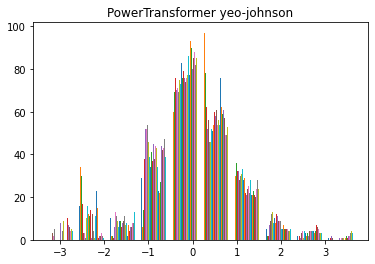

In [ ]:
from sklearn.preprocessing import PowerTransformer
X_trans = PowerTransformer(method='yeo-johnson').fit_transform(train_gas)
plt.hist(X_trans)
plt.title('PowerTransformer yeo-johnson')
plt.show()

In [ ]:
X = pd.DataFrame(X_trans)
mean = pd.DataFrame(X.mean()).transpose()

In [ ]:
X = pd.concat([X, mean], axis = 0)
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,5.666950e-01,6.019464e-01,3.678753e-01,1.910858e-01,2.342256e-01,1.893284e-01,1.307675e-01,5.940466e-02,1.957899e-01,3.457432e-01,2.790061e-01,2.113892e-01,2.271219e-01,2.196709e-01,2.745767e-01,3.836037e-01,3.872161e-01,4.144163e-01,4.162142e-01,4.578755e-01,6.035279e-01,4.869266e-01,4.722954e-01,4.550282e-01,5.105603e-01,5.401199e-01,5.509748e-01,5.387368e-01,6.038451e-01,9.098056e-01
1,-1.986682e+00,5.294284e-01,1.100283e+00,3.794373e-01,2.671543e-01,3.581821e-01,3.812078e-01,3.078033e-01,2.207744e-01,3.779031e-01,3.144453e-01,2.883525e-01,3.165824e-01,2.914396e-01,3.277773e-01,4.067720e-01,3.941056e-01,3.544252e-01,3.859299e-01,3.655037e-01,4.371653e-01,4.587884e-01,3.168983e-01,2.790480e-01,2.505889e-01,2.724694e-01,2.179223e-01,3.212734e-01,3.186117e-01,3.247994e-01
2,1.239858e+00,1.052163e+00,4.729168e-01,7.320278e-02,2.270791e-02,-6.004724e-01,-3.017108e-01,-1.001956e-01,6.902544e-03,1.154395e-01,2.117842e-02,-2.007282e-01,-2.577984e-01,-1.860149e-01,-1.944367e-01,-1.316523e-01,-1.893258e-01,-2.791204e-01,-2.402154e-01,-2.228270e-01,-2.197809e+00,-2.429499e+00,-7.971982e-01,-4.329414e-01,-3.337098e-01,-4.104581e-01,-3.226846e-01,-1.881913e-01,9.238932e-03,9.751461e-02
3,5.007316e-01,7.081570e-01,3.571003e-01,-1.078227e-01,-1.540742e-01,3.887213e-02,-6.310271e-01,-6.411713e-01,-1.107431e-01,-6.388719e-02,-1.347942e-01,-2.961241e-01,-3.958681e-01,-2.520335e-01,-2.469351e-01,-2.831078e-01,-3.030034e-01,2.379719e-01,-4.054087e-02,1.573662e-01,-2.197809e+00,-1.342870e+00,-2.349270e-01,-1.750079e-02,-1.976036e-01,-3.632513e-01,-1.189813e-01,-1.706369e-01,-3.807855e-01,2.797613e-01
4,1.006596e+00,9.065080e-01,5.543356e-01,-7.504212e-02,-1.507158e-01,-1.207753e-01,-2.140532e-01,2.973437e-01,4.872436e-01,4.759013e-01,2.249392e-01,-3.091895e-01,-2.685047e-01,-2.455803e-01,-2.462232e-01,-1.239913e-01,-9.665554e-02,-1.703631e-01,-8.936903e-02,-6.865036e-02,6.128070e-01,8.804247e-02,-5.719017e-02,-1.486499e-01,-1.511946e-01,-1.510892e-01,-1.307215e-01,7.912783e-02,8.430949e-02,1.645089e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,-4.871468e-01,-8.305270e-03,-2.143616e+00,-1.598012e+00,2.142937e-01,3.563906e-01,-2.834710e-01,-1.022200e+00,1.238060e-02,1.386144e-01,1.179678e-01,1.411716e-02,-1.550947e-01,-2.073427e-01,-1.907594e-01,-1.028924e-01,-1.534459e-01,-1.529261e-01,-1.967587e-01,-2.009437e-01,-1.096964e-02,-2.876837e-01,-1.263073e-01,-5.411353e-02,-2.388124e-01,-2.795858e-01,-3.252500e-01,-3.481841e-01,-2.354114e-01,-2.631205e-01
228,-1.832002e+00,4.885736e-01,-2.143616e+00,8.137251e-02,-8.099659e-02,-3.856494e-01,-5.801605e-01,-5.296641e-01,-5.767834e-01,-4.808760e-01,-2.445230e+00,-9.120649e-02,-1.338479e-01,-6.504989e-01,-6.368568e-01,-7.177359e-01,-9.193919e-01,-6.622156e-01,-6.401728e-01,-7.824857e-01,-4.600286e-01,-6.409391e-01,-7.485062e-01,-6.295504e-01,-6.404995e-01,-7.908563e-01,-7.389437e-01,-6.744952e-01,-6.708521e-01,-7.978791e-01
229,-4.215992e-01,4.480498e-02,-1.314489e+00,3.665706e-01,3.082019e-01,3.280331e-01,-2.234439e-03,2.000820e-01,-6.827688e-03,-3.983929e-02,6.796030e-01,4.120440e-01,-1.654536e-01,-2.054592e-01,-1.204348e-01,-4.501406e-02,-9.069186e-04,-1.328913e-01,-2.887989e-02,-2.447365e-01,-9.070860e-02,-2.475370e-01,-4.886185e-01,-4.062869e-01,-3.871906e-01,-5.155004e-01,-6.142035e-01,-5.534519e-01,-3.956577e-01,-2.734869e-01
230,-9.072583e-01,-2.096677e-01,-2.143616e+00,5.744735e-01,4.584598e-01,2.492505e-01,-1.087499e-01,8.967959e-02,5.481493e-02,-6.371771e-01,-2.445230e+00,6.297878e-02,1.183883e-01,-6.276061e-02,5.218479e-03,1.289065e-02,6.290787e-02,9.168569e-03,1.149967e-01,-7.576266e-02,1.048116e-01,-8.494394e-02,-2.144369e-01,-6.469582e-02,-8.464811e-02,1.171548e-01,1.585750e-01,1.343305e-01,-2.709869e-02,-1.264010e-01


In [ ]:
X['mean'] = X.mean()
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,mean
0,0.566695,0.601946,0.367875,0.191086,0.234226,0.189328,0.130767,0.059405,0.195790,0.345743,0.279006,0.211389,0.227122,0.219671,0.274577,0.383604,0.387216,0.414416,0.416214,0.457876,0.603528,0.486927,0.472295,0.455028,0.510560,0.540120,0.550975,0.538737,0.603845,0.909806,-1.831147e-16
1,-1.986682,0.529428,1.100283,0.379437,0.267154,0.358182,0.381208,0.307803,0.220774,0.377903,0.314445,0.288352,0.316582,0.291440,0.327777,0.406772,0.394106,0.354425,0.385930,0.365504,0.437165,0.458788,0.316898,0.279048,0.250589,0.272469,0.217922,0.321273,0.318612,0.324799,-3.616636e-17
2,1.239858,1.052163,0.472917,0.073203,0.022708,-0.600472,-0.301711,-0.100196,0.006903,0.115440,0.021178,-0.200728,-0.257798,-0.186015,-0.194437,-0.131652,-0.189326,-0.279120,-0.240215,-0.222827,-2.197809,-2.429499,-0.797198,-0.432941,-0.333710,-0.410458,-0.322685,-0.188191,0.009239,0.097515,-1.730218e-17
3,0.500732,0.708157,0.357100,-0.107823,-0.154074,0.038872,-0.631027,-0.641171,-0.110743,-0.063887,-0.134794,-0.296124,-0.395868,-0.252034,-0.246935,-0.283108,-0.303003,0.237972,-0.040541,0.157366,-2.197809,-1.342870,-0.234927,-0.017501,-0.197604,-0.363251,-0.118981,-0.170637,-0.380785,0.279761,4.248646e-16
4,1.006596,0.906508,0.554336,-0.075042,-0.150716,-0.120775,-0.214053,0.297344,0.487244,0.475901,0.224939,-0.309189,-0.268505,-0.245580,-0.246223,-0.123991,-0.096656,-0.170363,-0.089369,-0.068650,0.612807,0.088042,-0.057190,-0.148650,-0.151195,-0.151089,-0.130721,0.079128,0.084309,0.164509,5.911577e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,-0.001383,-0.110909,-0.286126,-0.667865,-0.875813,-0.996229,-1.038384,-0.919211,-0.752181,-0.607550,-0.700735,-0.728145,-0.684360,-0.674205,-0.577867,-0.489055,-0.484026,-0.485592,-0.447478,-0.450944,-0.257502,-0.404234,-0.487767,-0.774336,-0.315484,-0.317356,-0.263986,-0.272665,-0.259351,-0.316601,NaN
227,-0.487147,-0.008305,-2.143616,-1.598012,0.214294,0.356391,-0.283471,-1.022200,0.012381,0.138614,0.117968,0.014117,-0.155095,-0.207343,-0.190759,-0.102892,-0.153446,-0.152926,-0.196759,-0.200944,-0.010970,-0.287684,-0.126307,-0.054114,-0.238812,-0.279586,-0.325250,-0.348184,-0.235411,-0.263121,NaN
228,-1.832002,0.488574,-2.143616,0.081373,-0.080997,-0.385649,-0.580161,-0.529664,-0.576783,-0.480876,-2.445230,-0.091206,-0.133848,-0.650499,-0.636857,-0.717736,-0.919392,-0.662216,-0.640173,-0.782486,-0.460029,-0.640939,-0.748506,-0.629550,-0.640499,-0.790856,-0.738944,-0.674495,-0.670852,-0.797879,NaN
229,-0.421599,0.044805,-1.314489,0.366571,0.308202,0.328033,-0.002234,0.200082,-0.006828,-0.039839,0.679603,0.412044,-0.165454,-0.205459,-0.120435,-0.045014,-0.000907,-0.132891,-0.028880,-0.244736,-0.090709,-0.247537,-0.488619,-0.406287,-0.387191,-0.515500,-0.614203,-0.553452,-0.395658,-0.273487,NaN


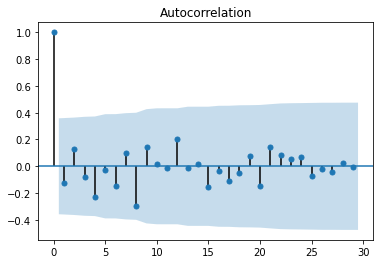

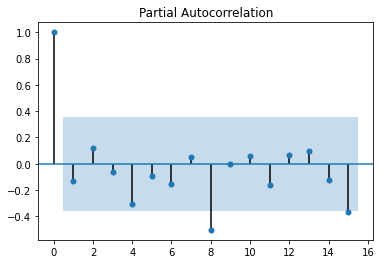

In [ ]:
#X = X.iloc[-1]
X = pd.DataFrame(X)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(X, lags = 29)
plot_pacf(X)
plt.show()

In [ ]:
stepwise_fit = auto_arima(X, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-649.318, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-657.318, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-655.318, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-655.318, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-777.395, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-653.318, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.552 seconds


,GAS_MONTH_1,GAS_MONTH_2,GAS_MONTH_3,GAS_MONTH_4,GAS_MONTH_5,GAS_MONTH_6,GAS_MONTH_7,GAS_MONTH_8,GAS_MONTH_9,GAS_MONTH_10,GAS_MONTH_11,GAS_MONTH_12,GAS_MONTH_13,GAS_MONTH_14,GAS_MONTH_15,GAS_MONTH_16,GAS_MONTH_17,GAS_MONTH_18,GAS_MONTH_19,GAS_MONTH_20,GAS_MONTH_21,GAS_MONTH_22,GAS_MONTH_23,GAS_MONTH_24,GAS_MONTH_25,GAS_MONTH_26,GAS_MONTH_27,GAS_MONTH_28,GAS_MONTH_29,GAS_MONTH_30,GAS_MONTH_31,GAS_MONTH_32,GAS_MONTH_33,GAS_MONTH_34,GAS_MONTH_35,GAS_MONTH_36,first6_avg
No,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,129303.0,162132.0,126960.0,118344.0,123348.0,110403.0,97038.0,82473.0,81354.0,80334.0,75747.0,70500.0,65016.0,61455.0,60612.0,59049.0,56967.0,55557.0,54384.0,51453.0,52503.0,47718.0,46356.0,44790.0,43866.0,42549.0,41910.0,39252.0,39261.0,46926.0,41079.0,48309.0,46437.0,36555.0,35895.0,35400.0,128415.0
3,1482.0,151515.0,235626.0,136260.0,126114.0,123303.0,114399.0,98718.0,82953.0,82551.0,78069.0,74856.0,69711.0,65205.0,63327.0,60165.0,57267.0,53136.0,53154.0,48078.0,45210.0,46650.0,41196.0,38886.0,36075.0,35217.0,33219.0,33723.0,32271.0,31977.0,36258.0,25923.0,24729.0,35724.0,26070.0,23388.0,129050.0
5,204702.0,237939.0,140163.0,107802.0,106329.0,60282.0,70878.0,72888.0,69816.0,65454.0,60054.0,49563.0,42678.0,42549.0,39663.0,37278.0,35049.0,31302.0,31227.0,29490.0,0.0,0.0,13917.0,19857.0,21729.0,20052.0,21618.0,22710.0,25584.0,27090.0,25713.0,32997.0,24762.0,26496.0,25263.0,25278.0,142869.5
7,122931.0,178464.0,125649.0,92613.0,93096.0,99567.0,54078.0,45219.0,63117.0,55056.0,51564.0,45282.0,37257.0,39834.0,37641.0,31953.0,31446.0,48615.0,37506.0,40932.0,0.0,4839.0,25617.0,30039.0,24693.0,20943.0,25638.0,23046.0,18423.0,30969.0,25932.0,24387.0,27138.0,24939.0,23334.0,21852.0,118720.0
9,176409.0,211509.0,150930.0,95274.0,93339.0,88740.0,75798.0,98001.0,101079.0,89520.0,72282.0,44712.0,42243.0,40095.0,37668.0,37560.0,38157.0,34578.0,35910.0,33882.0,52929.0,33858.0,30177.0,26553.0,25755.0,25230.0,25395.0,28158.0,27123.0,28479.0,24810.0,23709.0,28008.0,20445.0,19320.0,19827.0,136033.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,80178.0,75621.0,61350.0,53199.0,48366.0,41274.0,36843.0,33798.0,32988.0,29613.0,26802.0,28488.0,27231.0,24786.0,26313.0,25461.0,26175.0,25599.0,25392.0,23601.0,21450.0,20403.0,19854.0,13296.0,22113.0,21831.0,22734.0,21135.0,20505.0,19425.0,19368.0,18495.0,17349.0,16494.0,16344.0,13089.0,59998.0
716,48177.0,85713.0,0.0,12315.0,121689.0,123162.0,71886.0,30033.0,70137.0,66873.0,65700.0,59979.0,46977.0,41661.0,39807.0,38343.0,36234.0,35121.0,32538.0,30093.0,28695.0,23238.0,28353.0,29040.0,23772.0,22578.0,21570.0,19785.0,20931.0,20328.0,21036.0,21096.0,20781.0,20004.0,19869.0,20691.0,65176.0
718,3075.0,145722.0,0.0,108516.0,98457.0,72279.0,56502.0,50325.0,40173.0,34749.0,0.0,54738.0,47895.0,25527.0,24543.0,19230.0,15744.0,21243.0,20574.0,16308.0,16413.0,15288.0,14772.0,15888.0,15849.0,13680.0,14652.0,14562.0,13971.0,12393.0,10959.0,12138.0,10692.0,9918.0,9525.0,10137.0,71341.5


In [ ]:
series = train_gas.iloc[:,1]    # k번째 생산정
series = pd.DataFrame({"value":series})

NameError: ignored

In [ ]:
stepwise_fit = auto_arima(series, trace=True, suppress_warnings=True)  # auto_arima를 사용한 결과 seasonal하지는 않음.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=744.015, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=742.486, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=724.760, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=744.748, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=721.865, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=708.415, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=713.010, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=709.127, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=719.949, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=708.210, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=707.600, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=714.762, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=701.898, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=702.121, 

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return _x[self.order:]


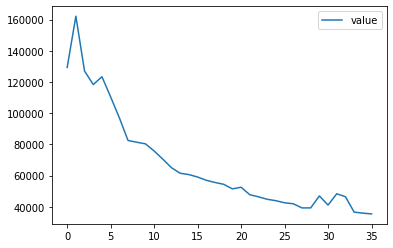

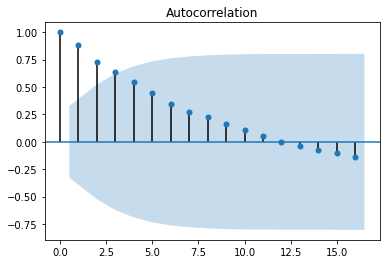

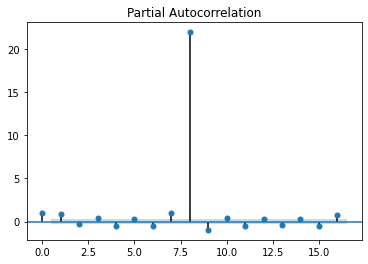

In [ ]:
series.plot()
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(series)
plot_pacf(series)
plt.show()

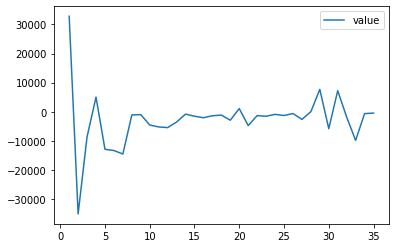

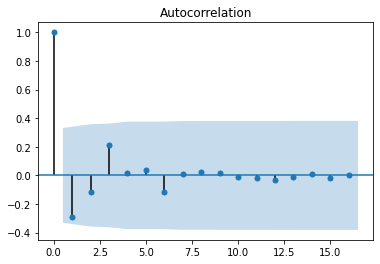

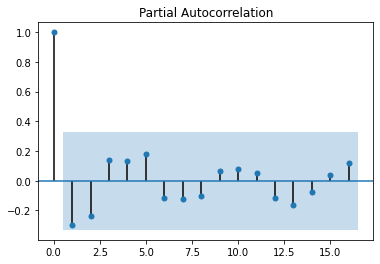

In [ ]:
diff_1=series.diff(periods=1).iloc[1:]
diff_1.plot()
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

In [ ]:
model = ARIMA(series, order=stepwise_fit.order)   # auto_arima로 찾은 p,d,q
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   35
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -365.856
Method:                       css-mle   S.D. of innovations           8142.381
Date:                Mon, 20 Dec 2021   AIC                            745.712
Time:                        23:39:47   BIC                            756.599
Sample:                             1   HQIC                           749.470
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -789.9732        nan        nan        nan         nan         nan
ar.L1.D.value     0.7293      0.180      4.061      0.000       0.377       1.081
ar.L2.D.value     0.1598      0.347     

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  interval : int
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt


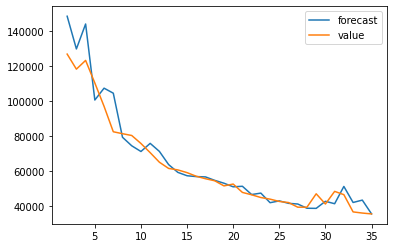

In [ ]:
pred = model_fit.plot_predict()

In [ ]:
forecast_data = model_fit.forecast(steps=6) #이후 6개월 예측
pred_arima_y = forecast_data[0].tolist()
avg_6 = sum(pred_arima_y)/6
avg_6

27361.731152842054

In [ ]:
train_notgas.drop(train_notgas.loc[train_notgas['NaN_cnt']==36].index, inplace=True)   #기존 생산 데이터 없는 생산정 제거

In [ ]:
train_notgas.replace(0, value = train_notgas.median(), inplace=True)  # 0을 모든 생산정의 미디안으로 대체
train_notgas

,CND_MONTH_1,CND_MONTH_2,CND_MONTH_3,CND_MONTH_4,CND_MONTH_5,CND_MONTH_6,CND_MONTH_7,CND_MONTH_8,CND_MONTH_9,CND_MONTH_10,CND_MONTH_11,CND_MONTH_12,CND_MONTH_13,CND_MONTH_14,CND_MONTH_15,CND_MONTH_16,CND_MONTH_17,CND_MONTH_18,CND_MONTH_19,CND_MONTH_20,CND_MONTH_21,CND_MONTH_22,CND_MONTH_23,CND_MONTH_24,CND_MONTH_25,CND_MONTH_26,CND_MONTH_27,CND_MONTH_28,CND_MONTH_29,CND_MONTH_30,CND_MONTH_31,CND_MONTH_32,CND_MONTH_33,CND_MONTH_34,CND_MONTH_35,CND_MONTH_36,NaN_cnt
No,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1323.0,18115.5,27102.0,22209.0,17874.0,13764.0,10518.0,10458.0,9618.0,7905.0,7479.0,6918.0,6429.0,5976.0,5808.0,5385.0,4695.0,5178.0,5400.0,5109.0,5196.0,4521.0,4083.0,3960.0,3864.0,3867.0,4731.0,4659.0,4644.0,5085.0,4368.0,4575.0,5037.0,4230.0,4203.0,3969.0,0
3,1548.0,14967.0,17265.0,31725.0,22710.0,17574.0,13458.0,11427.0,9747.0,9972.0,8718.0,8178.0,7389.0,6813.0,6696.0,6330.0,5859.0,5532.0,5211.0,5460.0,5004.0,4851.0,4377.0,4353.0,4035.0,3912.0,4527.0,4449.0,4245.0,4470.0,4476.0,3786.0,3651.0,4488.0,3726.0,3627.0,0
5,15096.0,297.0,44709.0,36618.0,30393.0,26373.0,22815.0,21705.0,18378.0,15417.0,14304.0,13470.0,12576.0,12159.0,11574.0,10428.0,9912.0,9345.0,10278.0,9150.0,3028.5,3150.0,7170.0,7617.0,7791.0,6876.0,7221.0,7440.0,7872.0,7986.0,6909.0,9312.0,6687.0,6072.0,5775.0,5709.0,0
7,159.0,42.0,26268.0,21939.0,19305.0,18705.0,8910.0,8817.0,10008.0,7650.0,7524.0,6954.0,5763.0,6096.0,5571.0,5040.0,4935.0,6435.0,5649.0,5430.0,3028.5,1374.0,4887.0,5268.0,4278.0,4005.0,4686.0,4443.0,5052.0,5433.0,4482.0,4416.0,5157.0,4101.0,3687.0,3927.0,0
9,3.0,18115.5,36255.0,24609.0,21972.0,19566.0,13191.0,12216.0,11082.0,9438.0,8967.0,8265.0,7815.0,7185.0,6534.0,6216.0,6561.0,5766.0,6477.0,5736.0,6831.0,5163.0,5358.0,5076.0,4710.0,4734.0,4668.0,5010.0,4962.0,4851.0,4521.0,3912.0,4752.0,3765.0,3345.0,3678.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,38094.0,28632.0,21108.0,15834.0,14853.0,12984.0,10782.0,10344.0,9753.0,8364.0,6891.0,6921.0,7197.0,6468.0,6063.0,5391.0,4611.0,4371.0,4128.0,3999.0,3729.0,3747.0,3528.0,3375.0,3789.0,3357.0,3378.0,3132.0,2976.0,3306.0,3114.0,2817.0,2592.0,2496.0,2862.0,2265.0,0
716,429.0,22653.0,17265.0,2739.0,34371.0,32061.0,24039.0,16848.0,19182.0,15522.0,12759.0,11427.0,10968.0,9978.0,9465.0,8907.0,8112.0,7509.0,7110.0,6477.0,6627.0,6312.0,6087.0,5634.0,4935.0,4734.0,4260.0,4104.0,4344.0,3939.0,3927.0,4236.0,4263.0,4113.0,4035.0,4089.0,0
718,201.0,39144.0,17265.0,24054.0,20775.0,17202.0,12540.0,10227.0,8970.0,7719.0,6033.0,12540.0,10386.0,6654.0,5229.0,4533.0,4764.0,5670.0,5241.0,4557.0,4320.0,3729.0,3585.0,3369.0,3246.0,3183.0,3201.0,2781.0,2949.0,2856.0,2778.0,2661.0,2757.0,2220.0,2040.0,1923.0,0


In [ ]:
train_notgas1 = train_notgas.drop(['NaN_cnt'],axis=1)
train_notgas = train_notgas1.transpose()        # NaN 개수 행 제거 및 transpose
train_notgas = train_notgas.reset_index(drop=False)

In [ ]:
train_notgas

No,index,1,3,5,7,9,11,19,21,22,23,25,27,29,31,33,34,62,64,79,81,83,85,87,92,94,96,98,100,102,104,108,110,112,116,122,124,126,130,132,...,619,621,623,627,635,637,640,642,644,646,648,650,652,654,658,660,662,664,666,668,670,672,674,676,678,680,682,684,686,688,690,692,694,696,706,708,716,718,720,722
0,CND_MONTH_1,1323.0,1548.0,15096.0,159.0,3.0,309.0,2883.0,15096.0,2907.0,15096.0,29592.0,19533.0,27483.0,18522.0,15096.0,15096.0,591.0,669.0,15096.0,15096.0,15096.0,15096.0,15096.0,36594.0,8136.0,4416.0,26544.0,44310.0,42840.0,18366.0,21153.0,32313.0,32217.0,19392.0,5430.0,15096.0,15096.0,7650.0,20199.0,...,20190.0,9723.0,14700.0,11376.0,36492.0,12837.0,9699.0,3813.0,9681.0,39588.0,31134.0,39087.0,26256.0,11775.0,9879.0,34644.0,12624.0,4371.0,14976.0,11679.0,576.0,1431.0,3156.0,19245.0,33495.0,27099.0,45051.0,24543.0,1419.0,41031.0,34410.0,6504.0,27459.0,13233.0,26460.0,38094.0,429.0,201.0,8169.0,1173.0
1,CND_MONTH_2,18115.5,14967.0,297.0,42.0,18115.5,165.0,99.0,4365.0,10620.0,18115.5,18115.5,18115.5,18115.5,18115.5,18115.5,7833.0,312.0,372.0,18115.5,18115.5,18115.5,18115.5,18115.5,132.0,45591.0,17814.0,11532.0,23499.0,22362.0,52326.0,25065.0,17166.0,25743.0,24762.0,41616.0,28263.0,18115.5,31263.0,46425.0,...,18115.5,18115.5,18115.5,48480.0,54561.0,21786.0,18115.5,9477.0,18115.5,18115.5,18115.5,18115.5,48027.0,1181196.0,23844.0,34929.0,18115.5,39468.0,27639.0,31464.0,31209.0,43530.0,34863.0,28350.0,32925.0,29205.0,30420.0,36747.0,18115.5,48264.0,27906.0,18115.5,27222.0,4146.0,23676.0,28632.0,22653.0,39144.0,55356.0,21720.0
2,CND_MONTH_3,27102.0,17265.0,44709.0,26268.0,36255.0,20541.0,177.0,6213.0,7917.0,17265.0,17265.0,17265.0,72.0,17265.0,10824.0,8523.0,606.0,588.0,17265.0,17265.0,17265.0,17265.0,17265.0,17265.0,17265.0,17265.0,8817.0,19329.0,20397.0,21969.0,20772.0,13056.0,14184.0,16236.0,32877.0,26205.0,17265.0,23133.0,22698.0,...,26955.0,28785.0,46686.0,30738.0,39207.0,42027.0,22275.0,26064.0,27327.0,17265.0,20157.0,17265.0,17265.0,17265.0,17265.0,23940.0,19212.0,35193.0,17502.0,22092.0,26241.0,37233.0,31689.0,17889.0,23898.0,18984.0,19029.0,28323.0,5961.0,40143.0,16725.0,17622.0,35577.0,17265.0,17358.0,21108.0,17265.0,17265.0,2037.0,17265.0
3,CND_MONTH_4,22209.0,31725.0,36618.0,21939.0,24609.0,13623.0,117.0,15519.0,6459.0,15519.0,15519.0,15519.0,15519.0,15519.0,15189.0,8682.0,99.0,117.0,15519.0,15519.0,15519.0,15519.0,15519.0,5751.0,15519.0,15519.0,6864.0,14706.0,14721.0,20589.0,18630.0,8556.0,8778.0,11238.0,24609.0,23472.0,15519.0,16407.0,17010.0,...,28248.0,29796.0,18303.0,26031.0,41100.0,41775.0,12078.0,23493.0,16494.0,15519.0,12462.0,15519.0,6006.0,14643.0,15519.0,15549.0,24774.0,35925.0,18549.0,16170.0,26538.0,38058.0,32811.0,15720.0,17235.0,15795.0,12747.0,21480.0,19713.0,25143.0,13971.0,21279.0,23778.0,10908.0,11745.0,15834.0,2739.0,24054.0,23733.0,37113.0
4,CND_MONTH_5,17874.0,22710.0,30393.0,19305.0,21972.0,11592.0,414.0,150.0,11109.0,13288.5,372.0,156.0,297.0,180.0,8805.0,13288.5,153.0,156.0,13288.5,13288.5,13288.5,13288.5,13288.5,17091.0,20610.0,17847.0,6600.0,13164.0,12687.0,15498.0,13692.0,7473.0,7350.0,7173.0,23799.0,11553.0,13288.5,11832.0,13725.0,...,19557.0,18837.0,15558.0,16674.0,40086.0,38862.0,7185.0,14904.0,12684.0,13288.5,10473.0,13288.5,23445.0,23832.0,13288.5,14346.0,21294.0,29772.0,14535.0,10530.0,22662.0,31098.0,26307.0,11301.0,15885.0,15192.0,11919.0,21486.0,16635.0,21147.0,11541.0,16197.0,21954.0,9711.0,11382.0,14853.0,34371.0,20775.0,21957.0,26001.0
5,CND_MONTH_6,13764.0,17574.0,26373.0,18705.0,19566.0,9003.0,288.0,189.0,6075.0,11916.0,11916.0,11916.0,11916.0,21.0,2808.0,150.0,48.0,51.0,11916.0,11916.0,11916.0,11916.0,11916.0,12873.0,23112.0,22626.0,5937.0,10323.0,9258.0,13743.0,11538.0,5940.0,5859.0,6288.0,19050.0,7317.0,270.0,8706.0,9585.0,...,12408.0,12507.0,10818.0,12156.0,34533.0,31497.0,6891.0,11931.0,12924.0,11916.0,14685.0,11916.0,19947.0,20808.0,25509.0,11901.0,20037.0,20241.0,11955.0,11226.0,15978.0,21402.0,17928.0,10425.0,13380.0,13116.0,9897.0,18696.0,16197.0,17757.0,9000.0,13989.0,18480.0

In [ ]:
series = train_notgas.iloc[:,1]    # k번째 생산정
series = pd.DataFrame({"value":series})
stepwise_fit = auto_arima(series, trace=True, suppress_warnings=True)  # auto_arima를 사용한 결과 seasonal하지는 않음.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=675.583, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=670.661, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=673.613, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=649.494, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=645.928, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(3,1,1)(0,0,0)[0

In [ ]:
model = ARIMA(series, order=stepwise_fit.order)   # auto_arima로 찾은 p,d,q
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   35
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -365.856
Method:                       css-mle   S.D. of innovations           8142.381
Date:                Mon, 20 Dec 2021   AIC                            745.712
Time:                        23:41:44   BIC                            756.599
Sample:                             1   HQIC                           749.470
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -789.9732        nan        nan        nan         nan         nan
ar.L1.D.value     0.7293      0.180      4.061      0.000       0.377       1.081
ar.L2.D.value     0.1598      0.347     

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  interval : int
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = train_notgas.iloc[:,1]    # k번째 생산정
series = pd.DataFrame({"value":series})
series

,value
0,1323.0
1,18115.5
2,27102.0
3,22209.0
4,17874.0
5,13764.0
6,10518.0
7,10458.0
8,9618.0
9,7905.0
